<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: рекомендательные системы</center></h2>

# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

# Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math

Загрузим данные и проведем предобраотку данных как на семинаре.

In [2]:
# !kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop
# !unzip articles-sharing-reading-from-cit-deskdrop.zip -d articles

In [3]:
articles_df = pd.read_csv("../input/kagglearticles/shared_articles.csv")
articles_df = articles_df[articles_df["eventType"] == "CONTENT SHARED"]
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [4]:
interactions_df = pd.read_csv("../input/kagglearticles/users_interactions.csv")
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [5]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [6]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   "VIEW": 1.0,
   "LIKE": 2.0, 
   "BOOKMARK": 2.5, 
   "FOLLOW": 3.0,
   "COMMENT CREATED": 4.0,  
}

interactions_df["eventStrength"] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [7]:
users_interactions_count_df = (
    interactions_df
    .groupby(["personId", "contentId"])
    .first()
    .reset_index()
    .groupby("personId").size())
print("# users:", len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]]
print("# users with at least 5 interactions:",len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [8]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [9]:
print(f"# interactions before: {interactions_df.shape}")
print(f"# interactions after: {interactions_from_selected_users_df.shape}")

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглажиываем полученный результат, взяв от него логарифм.

In [10]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"]).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(["personId", "contentId"])
)
interactions_full_df["last_timestamp"] = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"])["timestamp"].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [11]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print(f"# interactions on Train set: {len(interactions_train_df)}")
print(f"# interactions on Test set: {len(interactions_test_df)}")

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [12]:
interactions = (
    interactions_train_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"contentId": "true_train"})
    .set_index("personId")
)

interactions["true_test"] = (
    interactions_test_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), "true_test"] = [
    "" for x in range(len(interactions.loc[pd.isnull(interactions.true_test), "true_test"]))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


# Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [13]:
!pip install lightfm

In [14]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Задание 1 (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [15]:
interactions_train_df.head()

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093


In [16]:
from scipy.sparse import csr_matrix


def create_interaction_matrix(df, users, contents):
    user_id, content_id, strength = interactions_train_df['personId'].values, interactions_train_df['contentId'].values, interactions_train_df['eventStrength'].values
    mtx = pd.DataFrame(0, index = users, columns = contents)
    for i in range(len(user_id)):
        if strength[i] is not np.nan:
            mtx.loc[user_id[i], content_id[i]] = strength[i]
        else:
            mtx.loc[user_id[i], content_id[i]] = 0
    return csr_matrix(mtx.values)

In [17]:
full_users = pd.concat([interactions_train_df['personId'], interactions_test_df['personId']])
full_content = pd.concat([interactions_train_df['contentId'], interactions_test_df['contentId']])

users_set , content_set = set(full_users), set(full_content)

In [18]:
# Ваш код здесь
data_train = create_interaction_matrix(interactions_train_df, users_set , content_set)
data_test = create_interaction_matrix(interactions_test_df, users_set , content_set)

In [19]:
np.isnan(data_train.data).any()
np.isnan(data_test.data).any()
data_train.data = np.nan_to_num(data_train.data)
data_test.data = np.nan_to_num(data_test.data)
data_train.eliminate_zeros()
data_test.eliminate_zeros()

## Задание 2 (1 балл)

Обучите модель LightFM с `loss="warp"` и посчитайте *precision@10* на тесте.

In [20]:
# Ваш код здесь
model = LightFM(loss='warp')
model.fit(data_train)

In [21]:
train_precision = precision_at_k(model, data_train).mean()
test_precision = precision_at_k(model, data_test).mean()
print(f"Train precision@k: {train_precision} | Test precision@k: {test_precision}")

Train precision@k: 0.13291366398334503 | Test precision@k: 0.13291366398334503


## Задание 3 (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss="warp"` и посчитайте precision@10 на тесте.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Ваш код здесь
vectorizer = TfidfVectorizer()

feat = vectorizer.fit_transform(articles_df['text'])

model2 = LightFM(loss='warp')
model2.fit(data_train, item_features=feat)

train_precision = precision_at_k(model2, data_train, item_features=feat).mean()
test_precision = precision_at_k(model2, data_test, item_features=feat).mean()
print(f"Train precision@k: {train_precision} | Test precision@k: {test_precision}")

Train precision@k: 0.10863309353590012 | Test precision@k: 0.10863309353590012


## Задание 4 (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

Source: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [23]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


# Ваш код здесь
nltk.download('stopwords')
stop_word_list = stopwords.words('english')  
my_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def process_words(in_str):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", in_str).lower().split()
    return [my_stemmer.stem(word) for word in words if word not in stop_word_list]

In [25]:
vectorizer2 = TfidfVectorizer(analyzer='word', tokenizer=process_words)

feat2 = vectorizer2.fit_transform(articles_df['text'])

model3 = LightFM(loss='warp')
model3.fit(data_train, item_features=feat2, epochs=17)

train_precision = precision_at_k(model3, data_train, item_features=feat2).mean()
test_precision = precision_at_k(model3, data_test, item_features=feat2).mean()
print(f"Train precision@k: {train_precision} | Test precision@k: {test_precision}")

Train precision@k: 0.2296762615442276 | Test precision@k: 0.2296762615442276


Улучшилось ли качество предсказания?

## Задание 5 (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

In [26]:
# Ваш код здесь
def search_params(components_num, epoch_num, max_sampled):
    check_model = LightFM(loss="warp", no_components=int(components_num), max_sampled=max_sampled)
    check_model.fit(data_train, item_features=feat2, epochs=int(epoch_num))
    return precision_at_k(check_model, data_test, item_features=feat2).mean()

Я мгко говоря охренел от того, что существует такое применение Байеса
https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f \
И это 
https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb

In [27]:
from bayes_opt import BayesianOptimization


# параметры вообще на шару и максимально тупо взял
parameter_list = {
    'components_num': (10, 30), 
    "max_sampled": (5, 15),
    "epoch_num": (15, 30)}
my_optimizer = BayesianOptimization(f=search_params, pbounds=parameter_list, random_state=192)
my_optimizer.maximize(init_points=4, n_iter=5)

print(my_optimizer.max)

|   iter    |  target   | compon... | epoch_num | max_sa... |
-------------------------------------------------------------
|  1        |  0.358    |  25.15    |  20.49    |  9.232    |
|  2        |  0.349    |  28.64    |  15.88    |  9.46     |
|  3        |  0.2908   |  16.18    |  17.58    |  11.66    |
|  4        |  0.2395   |  12.58    |  16.98    |  8.969    |
|  5        |  0.4293   |  30.0     |  24.25    |  15.0     |
|  6        |  0.4107   |  25.26    |  30.0     |  15.0     |
|  7        |  0.3802   |  30.0     |  30.0     |  5.0      |
|  8        |  0.449    |  30.0     |  30.0     |  15.0     |
|  9        |  0.44     |  30.0     |  30.0     |  12.64    |
{'target': 0.44901081919670105, 'params': {'components_num': 30.0, 'epoch_num': 30.0, 'max_sampled': 15.0}}


In [28]:
model_best = LightFM(loss="warp", no_components=int(my_optimizer.max['params']['components_num']), 
                     max_sampled=int(my_optimizer.max['params']['max_sampled']))

model_best.fit(data_train, item_features=feat2, epochs=int(my_optimizer.max['params']['epoch_num']))

train_precision = precision_at_k(model_best, data_train, item_features=feat2).mean()
test_precision = precision_at_k(model_best, data_test, item_features=feat2).mean()
print(f"Train precision@k: {train_precision} | Test precision@k: {test_precision}")

Train precision@k: 0.45521584153175354 | Test precision@k: 0.45521584153175354


**Мораль** \
Хачу на фкн учить байеса, ибо курсеру закрыли. Хотелось бы еще поиграться с параметрами, но по Москве уже 12ый час\
А еще мемы посвящается Александру Плахину и прочим токсикам, у которых не бакалавриат, а сплошной чилл да иад. Не то что у ПМа в МИЭМе, который подыхает даже на 4ом курсе
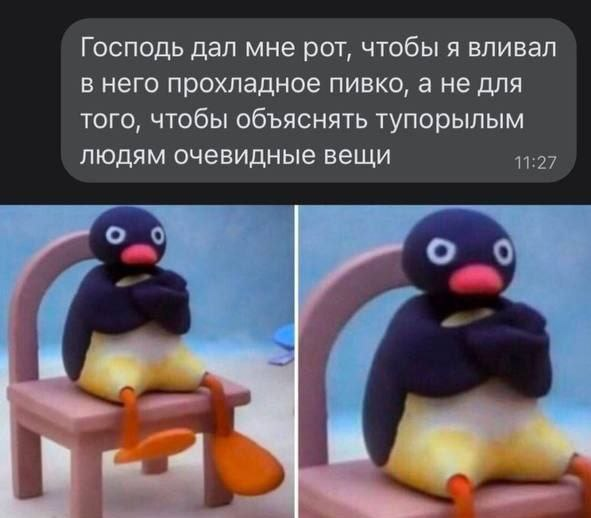

## Бонусное задание (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [29]:
# Ваш код здесь